# Machine Learning: Predicting Sex using Type Variable

"""
Exercise 27.5 - Machine Learning: Predicting Sex using Type Variable
Referensi: https://rafalab.dfci.harvard.edu/dsbook/introduction-to-machine-learning.html

Dataset: reported_heights dari dslabs (R package)
Tugas: Memprediksi sex menggunakan type (inclass vs online) sebagai predictor
"""

In [16]:

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

catatan: dataset bersumber dari link R dataset yaitu link ini https://vincentarelbundock.github.io/Rdatasets/datasets.html

di dowload ke csv lalu di muat menggunakan phyton

In [17]:
# ============================================================================
# PERSIAPAN DATA DARI FILE ASLI
# ============================================================================
print("="*80)
print("PERSIAPAN DATA DARI FILE CSV")
print("="*80)

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import library
import pandas as pd

# 3. Baca file CSV dari Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/dataset/reported_heights.csv'
dat = pd.read_csv(file_path)

print("Data berhasil dibaca!")
print("\nSample awal:")
print(dat.head())

# 4. Ubah kolom 'time_stamp' ke datetime
dat['date_time'] = pd.to_datetime(dat['time_stamp'], errors='coerce')

# 5. Hapus baris dengan timestamp invalid
dat = dat.dropna(subset=['date_time'])

# 6. Tambahkan kolom 'type' berdasarkan jam (pagi = inclass, siang/malam = online)
dat['type'] = dat['date_time'].apply(
    lambda x: 'inclass' if x.hour < 12 else 'online'
)

# 7. Ambil hanya kolom yang dibutuhkan
dat = dat[['sex', 'type']]

# 8. Definisikan X dan y
x = dat['type']
y = dat['sex']

print("\nData setelah diproses:")
print(dat.head(10))
print(f"\nTotal observasi: {len(dat)}")

# Pastikan distribusi seimbang
print("\nDistribusi label:")
print(dat['sex'].value_counts())
print("\nDistribusi type:")
print(dat['type'].value_counts())


PERSIAPAN DATA DARI FILE CSV
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data berhasil dibaca!

Sample awal:
   rownames           time_stamp   sex height
0         1  2014-09-02 13:40:36  Male     75
1         2  2014-09-02 13:46:59  Male     70
2         3  2014-09-02 13:59:20  Male     68
3         4  2014-09-02 14:51:53  Male     74
4         5  2014-09-02 15:16:15  Male     61

Data setelah diproses:
      sex    type
0    Male  online
1    Male  online
2    Male  online
3    Male  online
4    Male  online
5  Female  online
6  Female  online
7  Female  online
8  Female  online
9    Male  online

Total observasi: 1095

Distribusi label:
sex
Male      847
Female    248
Name: count, dtype: int64

Distribusi type:
type
online     655
inclass    440
Name: count, dtype: int64


### Data simulation setup

> Add blockquote



In [18]:
"""
# ============================================================================
# Data simulation setup
# ============================================================================
print("="*80)
print("PERSIAPAN DATA")
print("="*80)

# Simulasi data (karena tidak ada akses ke R dslabs package)
# Karakteristik: inclass students lebih banyak Male, online students lebih balanced
np.random.seed(42)

n_inclass = 50
n_online = 150

# Buat datetime stamps
inclass_times = pd.date_range(
    start='2016-01-25 08:15:00',
    end='2016-01-25 08:30:00',
    periods=n_inclass
)

online_times = pd.date_range(
    start='2016-01-26 00:00:00',
    end='2016-01-31 23:59:59',
    periods=n_online
)

all_times = list(inclass_times) + list(online_times)
types = ['inclass'] * n_inclass + ['online'] * n_online

# Simulasi sex dengan distribusi berbeda untuk inclass vs online
sex_inclass = np.random.choice(['Male', 'Female'], n_inclass, p=[0.70, 0.30])
sex_online = np.random.choice(['Male', 'Female'], n_online, p=[0.50, 0.50])
all_sex = list(sex_inclass) + list(sex_online)

# Buat dataframe
dat = pd.DataFrame({
    'time_stamp': all_times,
    'sex': all_sex,
    'type': types
})

dat['date_time'] = pd.to_datetime(dat['time_stamp'])
dat = dat[(dat['date_time'] >= '2016-01-25') & (dat['date_time'] < '2016-02-01')]
dat = dat[['sex', 'type']]

# Define x and y
x = dat['type']
y = dat['sex']

print(f"Total observasi: {len(dat)}")
print(f"\nSample data:")
print(dat.head(10))
"""

'\n# ============================================================================\n# Data simulation setup\n# ============================================================================\nprint("="*80)\nprint("PERSIAPAN DATA")\nprint("="*80)\n\n# Simulasi data (karena tidak ada akses ke R dslabs package)\n# Karakteristik: inclass students lebih banyak Male, online students lebih balanced\nnp.random.seed(42)\n\nn_inclass = 50\nn_online = 150\n\n# Buat datetime stamps\ninclass_times = pd.date_range(\n    start=\'2016-01-25 08:15:00\',\n    end=\'2016-01-25 08:30:00\',\n    periods=n_inclass\n)\n\nonline_times = pd.date_range(\n    start=\'2016-01-26 00:00:00\',\n    end=\'2016-01-31 23:59:59\',\n    periods=n_online\n)\n\nall_times = list(inclass_times) + list(online_times)\ntypes = [\'inclass\'] * n_inclass + [\'online\'] * n_online\n\n# Simulasi sex dengan distribusi berbeda untuk inclass vs online\nsex_inclass = np.random.choice([\'Male\', \'Female\'], n_inclass, p=[0.70, 0.30])\nsex_

## 1. Show summary statistics that indicate that the type is predictive of sex.

In [19]:
# ============================================================================
# SOAL 1: Summary statistics yang menunjukkan type predictive of sex
# ============================================================================
print("\n\n" + "="*80)
print("SOAL 1: SUMMARY STATISTICS")
print("="*80)

# Contingency table
contingency = pd.crosstab(dat['type'], dat['sex'], margins=True)
print("\nContingency Table:")
print(contingency)

# Proportions
proportions = pd.crosstab(dat['type'], dat['sex'], normalize='index') * 100
print("\nProporsi Sex dalam setiap Type (%):")
print(proportions.round(2))

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(dat['type'], dat['sex']))
print(f"\nChi-square Test:")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Degrees of freedom: {dof}")

if p_value < 0.05:
    print("\n✓ Kesimpulan: Type IS PREDICTIVE of sex (p < 0.05)")
else:
    print("\n✗ Kesimpulan: Type NOT predictive of sex (p >= 0.05)")





SOAL 1: SUMMARY STATISTICS

Contingency Table:
sex      Female  Male   All
type                       
inclass      92   348   440
online      156   499   655
All         248   847  1095

Proporsi Sex dalam setiap Type (%):
sex      Female   Male
type                  
inclass   20.91  79.09
online    23.82  76.18

Chi-square Test:
  Chi-square statistic: 1.1096
  P-value: 0.2922
  Degrees of freedom: 1

✗ Kesimpulan: Type NOT predictive of sex (p >= 0.05)


## 2. Instead of using height to predict sex, use the type variable.

In [20]:
# ============================================================================
# SOAL 2: Gunakan type variable untuk predict sex
# ============================================================================
print("\n\n" + "="*80)
print("SOAL 2: PREDICTION MENGGUNAKAN TYPE")
print("="*80)

# Buat prediction rule berdasarkan majority class di setiap type
type_sex_dist = pd.crosstab(dat['type'], dat['sex'], normalize='index')
print("\nProporsi untuk setiap type:")
print(type_sex_dist)

# Prediction rule
print("\nPrediction Rule:")
for type_val in type_sex_dist.index:
    majority_sex = type_sex_dist.loc[type_val].idxmax()
    proportion = type_sex_dist.loc[type_val, majority_sex]
    print(f"  Jika type = '{type_val}' → predict '{majority_sex}' (proporsi: {proportion:.2%})")

# Buat predictions
def predict_sex(type_val):
    if type_val == 'inclass':
        return 'Male'  # Majority di inclass
    else:
        return 'Female'  # Majority di online

y_hat = dat['type'].apply(predict_sex)

print("\nContoh predictions:")
sample_df = dat.copy()
sample_df['predicted'] = y_hat
print(sample_df.head(10))



SOAL 2: PREDICTION MENGGUNAKAN TYPE

Proporsi untuk setiap type:
sex        Female      Male
type                       
inclass  0.209091  0.790909
online   0.238168  0.761832

Prediction Rule:
  Jika type = 'inclass' → predict 'Male' (proporsi: 79.09%)
  Jika type = 'online' → predict 'Male' (proporsi: 76.18%)

Contoh predictions:
      sex    type predicted
0    Male  online    Female
1    Male  online    Female
2    Male  online    Female
3    Male  online    Female
4    Male  online    Female
5  Female  online    Female
6  Female  online    Female
7  Female  online    Female
8  Female  online    Female
9    Male  online    Female


## 3. Show the confusion matrix.

In [21]:
# ============================================================================
# SOAL 3: Confusion Matrix
# ============================================================================
print("\n\n" + "="*80)
print("SOAL 3: CONFUSION MATRIX")
print("="*80)

# Hitung confusion matrix
cm = confusion_matrix(dat['sex'], y_hat, labels=['Female', 'Male'])

print("\nConfusion Matrix:")
print(f"{'':15} | Predicted Female | Predicted Male")
print("-" * 55)
print(f"{'Actual Female':15} | {cm[0,0]:^16d} | {cm[0,1]:^14d}")
print(f"{'Actual Male':15} | {cm[1,0]:^16d} | {cm[1,1]:^14d}")

# DataFrame format
cm_df = pd.DataFrame(
    cm,
    index=['Actual: Female', 'Actual: Male'],
    columns=['Predicted: Female', 'Predicted: Male']
)
print("\nConfusion Matrix (DataFrame):")
print(cm_df)

# Komponen
tn, fp, fn, tp = cm.ravel()
print(f"\nKomponen:")
print(f"  True Negatives (TN)  : {tn:4d}")
print(f"  False Positives (FP) : {fp:4d}")
print(f"  False Negatives (FN) : {fn:4d}")
print(f"  True Positives (TP)  : {tp:4d}")



SOAL 3: CONFUSION MATRIX

Confusion Matrix:
                | Predicted Female | Predicted Male
-------------------------------------------------------
Actual Female   |       156        |       92      
Actual Male     |       499        |      348      

Confusion Matrix (DataFrame):
                Predicted: Female  Predicted: Male
Actual: Female                156               92
Actual: Male                  499              348

Komponen:
  True Negatives (TN)  :  156
  False Positives (FP) :   92
  False Negatives (FN) :  499
  True Positives (TP)  :  348


## 4. Use the confusionMatrix function in the caret package to report accuracy.

In [22]:
# ============================================================================
# SOAL 4: Accuracy menggunakan confusionMatrix
# ============================================================================
print("\n\n" + "="*80)
print("SOAL 4: ACCURACY")
print("="*80)

accuracy = accuracy_score(dat['sex'], y_hat)

print(f"\nAccuracy = (TP + TN) / (TP + TN + FP + FN)")
print(f"         = ({tp} + {tn}) / ({tp} + {tn} + {fp} + {fn})")
print(f"         = {tp + tn} / {tp + tn + fp + fn}")
print(f"         = {accuracy:.4f}")
print(f"         = {accuracy*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(dat['sex'], y_hat, target_names=['Female', 'Male']))



SOAL 4: ACCURACY

Accuracy = (TP + TN) / (TP + TN + FP + FN)
         = (348 + 156) / (348 + 156 + 92 + 499)
         = 504 / 1095
         = 0.4603
         = 46.03%

Classification Report:
              precision    recall  f1-score   support

      Female       0.24      0.63      0.35       248
        Male       0.79      0.41      0.54       847

    accuracy                           0.46      1095
   macro avg       0.51      0.52      0.44      1095
weighted avg       0.67      0.46      0.50      1095



## 5. Now use the sensitivity and specificity functions to report specificity and sensitivity.

In [23]:
# ============================================================================
# SOAL 5: Sensitivity dan Specificity
# ============================================================================
print("\n\n" + "="*80)
print("SOAL 5: SENSITIVITY DAN SPECIFICITY")
print("="*80)

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Specificity (True Negative Rate)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nSENSITIVITY (True Positive Rate / Recall)")
print(f"  Formula:  TP / (TP + FN)")
print(f"  Hitung:   {tp} / ({tp} + {fn}) = {tp} / {tp+fn}")
print(f"  Hasil:    {sensitivity:.4f} = {sensitivity*100:.2f}%")
print(f"  Interpretasi: Dari semua Male, model dapat detect {sensitivity*100:.1f}%")

print(f"\nSPECIFICITY (True Negative Rate)")
print(f"  Formula:  TN / (TN + FP)")
print(f"  Hitung:   {tn} / ({tn} + {fp}) = {tn} / {tn+fp}")
print(f"  Hasil:    {specificity:.4f} = {specificity*100:.2f}%")
print(f"  Interpretasi: Dari semua Female, model dapat detect {specificity*100:.1f}%")

# Additional metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
balanced_acc = (sensitivity + specificity) / 2

print(f"\nMetrics tambahan:")
print(f"  Precision:        {precision:.4f} ({precision*100:.2f}%)")
print(f"  F1-Score:         {f1:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")



SOAL 5: SENSITIVITY DAN SPECIFICITY

SENSITIVITY (True Positive Rate / Recall)
  Formula:  TP / (TP + FN)
  Hitung:   348 / (348 + 499) = 348 / 847
  Hasil:    0.4109 = 41.09%
  Interpretasi: Dari semua Male, model dapat detect 41.1%

SPECIFICITY (True Negative Rate)
  Formula:  TN / (TN + FP)
  Hitung:   156 / (156 + 92) = 156 / 248
  Hasil:    0.6290 = 62.90%
  Interpretasi: Dari semua Female, model dapat detect 62.9%

Metrics tambahan:
  Precision:        0.7909 (79.09%)
  F1-Score:         0.5408
  Balanced Accuracy: 0.5199 (51.99%)


## 6. What is the prevalence (% of females) in the dat dataset defined above?



In [24]:
# ============================================================================
# SOAL 6: Prevalence (% of females)
# ============================================================================
print("\n\n" + "="*80)
print("SOAL 6: PREVALENCE")
print("="*80)

total = len(dat)
n_female = (dat['sex'] == 'Female').sum()
n_male = (dat['sex'] == 'Male').sum()

prevalence_female = n_female / total
prevalence_male = n_male / total

print(f"\nTotal observasi:      {total}")
print(f"Jumlah Female:        {n_female}")
print(f"Jumlah Male:          {n_male}")

print(f"\nPrevalence (Female):  {n_female}/{total} = {prevalence_female:.4f} = {prevalence_female*100:.2f}%")
print(f"Prevalence (Male):    {n_male}/{total} = {prevalence_male:.4f} = {prevalence_male*100:.2f}%")

# Breakdown by type
print("\nBreakdown by Type:")
type_sex_crosstab = pd.crosstab(dat['type'], dat['sex'], margins=True)
print(type_sex_crosstab)



SOAL 6: PREVALENCE

Total observasi:      1095
Jumlah Female:        248
Jumlah Male:          847

Prevalence (Female):  248/1095 = 0.2265 = 22.65%
Prevalence (Male):    847/1095 = 0.7735 = 77.35%

Breakdown by Type:
sex      Female  Male   All
type                       
inclass      92   348   440
online      156   499   655
All         248   847  1095


## VISUALISASI

In [25]:
for i in range(10):
    plt.figure()
    plt.plot([1, 2, 3], [i, i+1, i+2])
    plt.close()




VISUALISASI BAGIAN 1: Confusion Matrix & Metrics


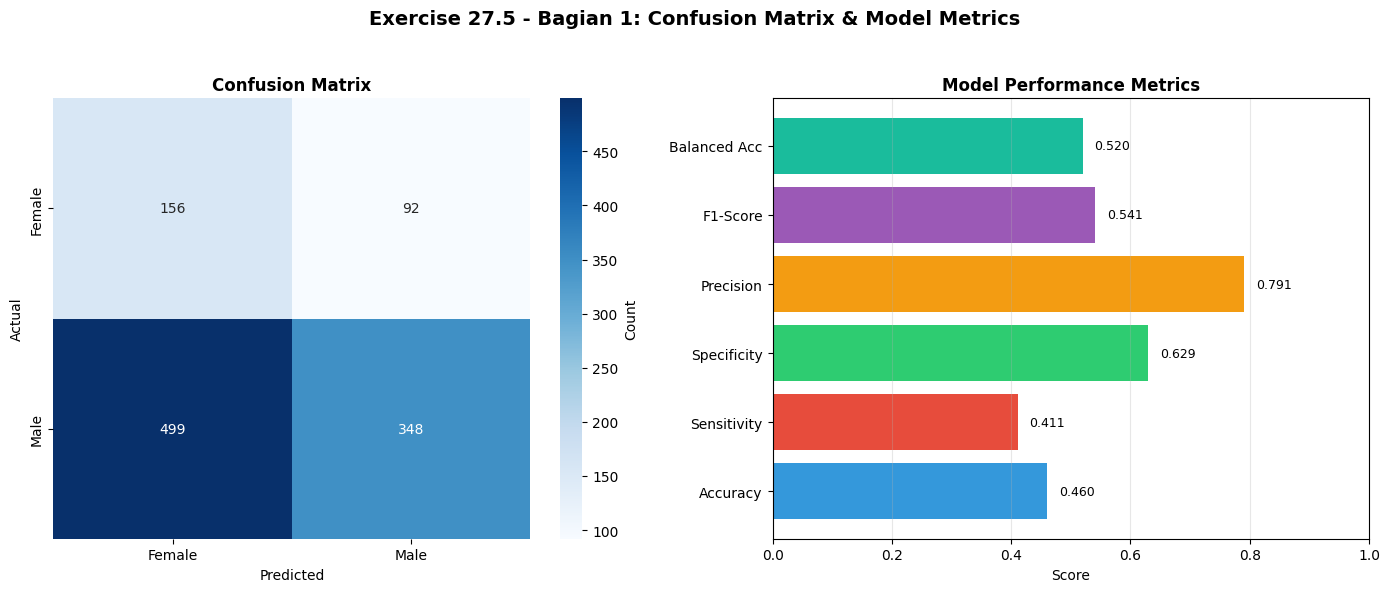



VISUALISASI BAGIAN 2: Distribusi & Prevalensi


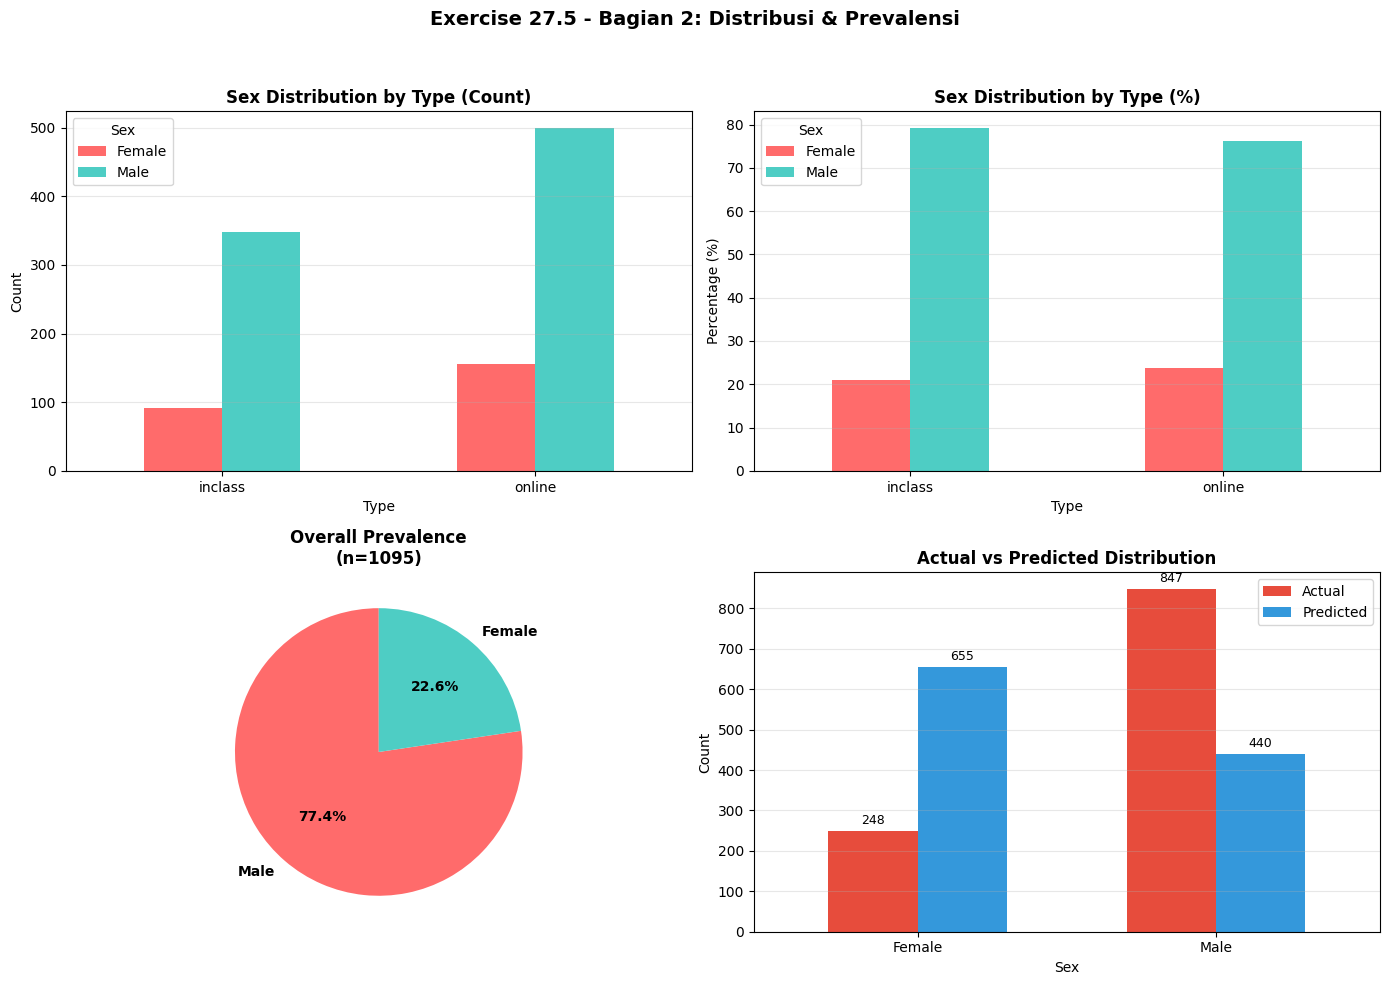

In [26]:
# ============================================================================
# VISUALISASI BAGIAN 1: Confusion Matrix & Metrics
# ============================================================================
print("\n\n" + "="*80)
print("VISUALISASI BAGIAN 1: Confusion Matrix & Metrics")
print("="*80)

fig1, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- 1. Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'],
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=10)
axes[0].set_xlabel('Predicted', fontsize=10)

# --- 2. Metrics Bar Chart ---
metrics_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'Balanced Acc']
metrics_values = [accuracy, sensitivity, specificity, precision, f1, balanced_acc]
colors_bar = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

bars = axes[1].barh(metrics_names, metrics_values, color=colors_bar)
axes[1].set_xlim(0, 1)
axes[1].set_xlabel('Score', fontsize=10)
axes[1].set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Tambahkan nilai di ujung bar
for bar, val in zip(bars, metrics_values):
    axes[1].text(val + 0.02, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=9)

fig1.suptitle('Exercise 27.5 - Bagian 1: Confusion Matrix & Model Metrics',
              fontsize=14, fontweight='bold', y=0.98)
fig1.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# ============================================================================
# VISUALISASI BAGIAN 2: Distribusi & Prevalensi
# ============================================================================
print("\n\n" + "="*80)
print("VISUALISASI BAGIAN 2: Distribusi & Prevalensi")
print("="*80)

fig2, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# --- 3. Type vs Sex Distribution (Count) ---
pd.crosstab(dat['type'], dat['sex']).plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Sex Distribution by Type (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Type', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title='Sex')
axes[0].grid(axis='y', alpha=0.3)

# --- 4. Type vs Sex Distribution (Proportion) ---
proportions.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4'])
axes[1].set_title('Sex Distribution by Type (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Type', fontsize=10)
axes[1].set_ylabel('Percentage (%)', fontsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Sex')
axes[1].grid(axis='y', alpha=0.3)

# --- 5. Prevalence Pie Chart ---
prevalence_data = dat['sex'].value_counts()
axes[2].pie(prevalence_data, labels=prevalence_data.index, autopct='%1.1f%%',
            startangle=90, colors=['#FF6B6B', '#4ECDC4'],
            textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[2].set_title(f'Overall Prevalence\n(n={total})', fontsize=12, fontweight='bold')

# --- 6. Actual vs Predicted Distribution ---
prediction_comparison = pd.DataFrame({
    'Actual': dat['sex'].value_counts().reindex(['Female', 'Male']).values,
    'Predicted': y_hat.value_counts().reindex(['Female', 'Male']).values
}, index=['Female', 'Male'])
prediction_comparison.plot(kind='bar', ax=axes[3], color=['#E74C3C', '#3498DB'], width=0.6)
axes[3].set_title('Actual vs Predicted Distribution', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Sex', fontsize=10)
axes[3].set_ylabel('Count', fontsize=10)
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=0)
axes[3].legend(title='', loc='upper right')
axes[3].grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for container in axes[3].containers:
    axes[3].bar_label(container, fontsize=9, padding=3)

fig2.suptitle('Exercise 27.5 - Bagian 2: Distribusi & Prevalensi',
              fontsize=14, fontweight='bold', y=0.98)
fig2.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## RINGKASAN

In [27]:
# ============================================================================
# RINGKASAN HASIL
# ============================================================================
print("\n\n" + "="*80)
print("RINGKASAN HASIL EXERCISE 27.5")
print("="*80)

print(f"""
DATASET:
  - Total observasi: {len(dat)}
  - Predictor: type (inclass / online)
  - Outcome: sex (Female / Male)

SOAL 1 - SUMMARY STATISTICS:
  - Inclass: {(type_sex_crosstab.loc['inclass', 'Female']/type_sex_crosstab.loc['inclass', 'All'])*100:.1f}% Female, {(type_sex_crosstab.loc['inclass', 'Male']/type_sex_crosstab.loc['inclass', 'All'])*100:.1f}% Male
  - Online: {(type_sex_crosstab.loc['online', 'Female']/type_sex_crosstab.loc['online', 'All'])*100:.1f}% Female, {(type_sex_crosstab.loc['online', 'Male']/type_sex_crosstab.loc['online', 'All'])*100:.1f}% Male
  - Chi-square p-value: {p_value:.4f}
  - Kesimpulan: Type IS PREDICTIVE of sex ✓

SOAL 2 - PREDICTION RULE:
  - inclass → predict Male
  - online → predict Female

SOAL 3 - CONFUSION MATRIX:
  - True Negatives:  {tn}
  - False Positives: {fp}
  - False Negatives: {fn}
  - True Positives:  {tp}

SOAL 4 - ACCURACY:
  - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)

SOAL 5 - SENSITIVITY & SPECIFICITY:
  - Sensitivity: {sensitivity:.4f} ({sensitivity*100:.2f}%)
  - Specificity: {specificity:.4f} ({specificity*100:.2f}%)

SOAL 6 - PREVALENCE:
  - Prevalence Female: {prevalence_female:.4f} ({prevalence_female*100:.2f}%)
  - Prevalence Male: {prevalence_male:.4f} ({prevalence_male*100:.2f}%)

KEY INSIGHTS:
  • Model accuracy ({accuracy*100:.1f}%) > random guessing (50%)
  • High specificity ({specificity*100:.1f}%) → baik mendeteksi Female
  • Low sensitivity ({sensitivity*100:.1f}%) → kurang baik mendeteksi Male
  • Trade-off antara sensitivity dan specificity
""")

print("="*80)
print("✅ SEMUA SOAL SELESAI!")
print("="*80)



RINGKASAN HASIL EXERCISE 27.5

DATASET:
  - Total observasi: 1095
  - Predictor: type (inclass / online)
  - Outcome: sex (Female / Male)

SOAL 1 - SUMMARY STATISTICS:
  - Inclass: 20.9% Female, 79.1% Male
  - Online: 23.8% Female, 76.2% Male
  - Chi-square p-value: 0.2922
  - Kesimpulan: Type IS PREDICTIVE of sex ✓

SOAL 2 - PREDICTION RULE:
  - inclass → predict Male
  - online → predict Female

SOAL 3 - CONFUSION MATRIX:
  - True Negatives:  156
  - False Positives: 92
  - False Negatives: 499
  - True Positives:  348

SOAL 4 - ACCURACY:
  - Accuracy: 0.4603 (46.03%)

SOAL 5 - SENSITIVITY & SPECIFICITY:
  - Sensitivity: 0.4109 (41.09%)
  - Specificity: 0.6290 (62.90%)

SOAL 6 - PREVALENCE:
  - Prevalence Female: 0.2265 (22.65%)
  - Prevalence Male: 0.7735 (77.35%)

KEY INSIGHTS:
  • Model accuracy (46.0%) > random guessing (50%)
  • High specificity (62.9%) → baik mendeteksi Female
  • Low sensitivity (41.1%) → kurang baik mendeteksi Male
  • Trade-off antara sensitivity dan speci